### Import libraries

In [59]:
import pandas as pd
import numpy as np
import ast

import scipy.stats as stats
from sklearn.utils.fixes import loguniform
import scipy as sp

from time import time
from scipy.sparse import hstack
from collections import Counter

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
#from xgboost import XGBClassifier
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from skmultilearn.problem_transform import LabelPowerset
from sklearn.neural_network import MLPClassifier
import scipy.stats as stats
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder

#from utility_functions import *

In [60]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mejia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mejia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [61]:
def Accuracy(y_true, y_pred):
    """
    Accuracy based on Jaccard Similarity Score
    :param y_true: ground truth
    :param y_pred: prediction
    :return: Jaccard Similarity Score
    """
    jaccard = np.minimum(y_true, y_pred).sum(axis=1) / np.maximum(y_true, y_pred).sum(axis=1)
    return jaccard.mean()


def print_ml_score(y_test, y_pred, clf):
    print('Classifier: ', clf.__class__.__name__)
    print('Accuracy Score: {}'.format(Accuracy(y_test, y_pred)))
    print("-----------------------------------")


def train_model(classifier, feature_vector_train, label_train, feature_vector_test, label_test):
    # fit the training set on the classifier
    clf = MultiOutputClassifier(classifier)
    clf.fit(feature_vector_train, label_train)

    # predict the labels on test set
    predictions = clf.predict(feature_vector_test)
    #print(pd.DataFrame(predictions, columns = multilabel.classes_))
    return print_ml_score(label_test, predictions, classifier)


def randomSearch(baseCLF, param_dist, X, y, iters=100, splits=3):

      best = dict()
      bestAcc = 0

      for i in tqdm(range(iters)): 
            
            params = dict()
            for param in param_dist.keys():
                  params[param] = random.choice(param_dist[param])

            if 'solver' in params and params['solver'] == 'liblinear':
                  params['penalty'] = 'l2'
            if 'loss' in params and params['loss'] == 'hinge':
                  params['penalty'] = 'l2'

            clf = ClassifierChain(baseCLF(class_weight='balanced', **params))
            
            kf = KFold(n_splits=splits)
            accKF = 0

            for train_index, test_index in kf.split(xtrain_tfidf_ngram):
                  X_train, X_test = X[train_index], X[test_index]
                  y_train, y_test = y[train_index], y[test_index]

                  clf.fit(X_train, y_train)
                  accKF += Accuracy(y_test, clf.predict(X_test))
            accKF /= splits
            
            if accKF > bestAcc:
                  #print(accKF)
                  bestAcc = accKF
                  best = params
      
      return bestAcc, best
      

In [62]:
# Notebook parameters
data_name = 'traning_data_cleaned_v02.csv'
data_path = '../data/'

In [63]:
# load data

df = pd.read_csv(data_path + data_name)
#df.drop(columns=['Unnamed: 0'], inplace=True)
df['tags'] = df['tags'].apply(lambda x: ast.literal_eval(x))
print(df.shape)
df.head()

(3126, 6)


,abstract,tags,title_x,all_text,cleaned_abstract,cleaned_all_text
0,When a production process requires two extreme...,"[O, D, G, E]",optimal adoption of complementary technologies,optimal adoption of complementary technologies...,production process require two extremely compl...,optimal adoption complementary technologies pr...
1,The Japanese banking crisis provides a natural...,"[G, E]",collateral damage: effects of the japanese ban...,collateral damage: effects of the japanese ban...,japanese bank crisis provide natural experimen...,collateral damage effect japanese bank crisis...
2,We consider a market with red and green worker...,[J],endogenous inequality in integrated labor mark...,endogenous inequality in integrated labor mark...,consider market red green workers label payof...,endogenous inequality integrate labor market t...
3,This paper presents a general-equilibrium mode...,"[J, R]","labor-market integration, investment in risky ...","labor-market integration, investment in risky ...",present general-equilibrium human capital inve...,labor-market integration investment risky hum...
4,This paper develops a theory of inequality and...,"[P, E, I, D]",unequal societies: income distribution and the...,unequal societies: income distribution and the...,develop theory inequality social contract aim ...,unequal societies income distribution social ...


In [ ]:
df.groupby("")

In [10]:
df['keep'] = df.tags.apply(lambda tags: 'Y' not in tags)
df = df[df.keep == True]

df.head()

,abstract,tags,title_x,all_text,cleaned_abstract,cleaned_all_text,keep
0,When a production process requires two extreme...,"[O, D, G, E]",optimal adoption of complementary technologies,optimal adoption of complementary technologies...,production process require two extremely compl...,optimal adoption complementary technologies pr...,True
1,The Japanese banking crisis provides a natural...,"[G, E]",collateral damage: effects of the japanese ban...,collateral damage: effects of the japanese ban...,japanese bank crisis provide natural experimen...,collateral damage effect japanese bank crisis...,True
2,We consider a market with red and green worker...,[J],endogenous inequality in integrated labor mark...,endogenous inequality in integrated labor mark...,consider market red green workers label payof...,endogenous inequality integrate labor market t...,True
3,This paper presents a general-equilibrium mode...,"[J, R]","labor-market integration, investment in risky ...","labor-market integration, investment in risky ...",present general-equilibrium human capital inve...,labor-market integration investment risky hum...,True
4,This paper develops a theory of inequality and...,"[P, E, I, D]",unequal societies: income distribution and the...,unequal societies: income distribution and the...,develop theory inequality social contract aim ...,unequal societies income distribution social ...,True


## Machine Learning: Abstract

### Feature Engineering
In this step, raw text data will be transformed into feature vectors using different
text representation.

In [11]:
# Convert outcome variable to one-hot encoding type
multilabel = MultiLabelBinarizer()
y = multilabel.fit_transform(df['tags'])
pd.DataFrame(y, columns = multilabel.classes_)

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,Z
0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3120,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3121,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3122,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3123,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0


In [12]:
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}',
                                   ngram_range=(1,3), max_features=3000)

X_tfidf_ngram = tfidf_vect_ngram.fit_transform(df['cleaned_all_text'])

print('X with TfIdf Ngram Vec Shape: ', X_tfidf_ngram.shape)

X with TfIdf Ngram Vec Shape:  (3125, 3000)


In [13]:
xtrain_tfidf_ngram, xtest_tfidf_ngram, ytrain_tfidf_ngram, ytest_tfidf_ngram = train_test_split(X_tfidf_ngram, y,
                                                                        test_size=0.1,
                                                                        random_state=123)


### Building Models

In this section we test several machine learning models in order to get the best one.

In [24]:
import random 
from sklearn.model_selection import KFold
from tqdm import tqdm
# specify parameters and distributions to sample from

param_dist = {'C': [0.001, 0.01, 0.1, 0.3, 0.5, 1],
              'loss': ['hinge', 'squared_hinge'],
              'multi_class': ['ovr', 'crammer_singer'],
            }

iters=100
splits = 3

best, params = randomSearch(LinearSVC, param_dist, xtrain_tfidf_ngram, ytrain_tfidf_ngram)

100%|██████████| 100/100 [02:20<00:00,  1.41s/it]


In [25]:
clf = ClassifierChain(LinearSVC(class_weight='balanced', **params)).fit(xtrain_tfidf_ngram, ytrain_tfidf_ngram)
preds = clf.predict(xtest_tfidf_ngram)

print_ml_score(ytest_tfidf_ngram, preds, clf)
print(params)

Classifier:  ClassifierChain
Accuracy Score: 0.5404609767229576
-----------------------------------
{'C': 0.5, 'loss': 'hinge', 'multi_class': 'ovr', 'penalty': 'l2'}


In [26]:
param_dist = {'C': [0.001, 0.01, 0.1, 0.3, 0.5, 1],
              'penalty' : ['l2', 'none'],
              'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'l1_ratio': [0.001, 0.01, 0.1, 0.3, 0.5, 1],
            }

iters=100
splits = 3

best, params = randomSearch(LogisticRegression, param_dist, xtrain_tfidf_ngram, ytrain_tfidf_ngram)

100%|██████████| 100/100 [06:12<00:00,  3.73s/it]


In [27]:
clf = ClassifierChain(LogisticRegression(class_weight='balanced', **params)).fit(xtrain_tfidf_ngram, ytrain_tfidf_ngram)
preds = clf.predict(xtest_tfidf_ngram)

print_ml_score(ytest_tfidf_ngram, preds, clf)
print(params)

Classifier:  ClassifierChain
Accuracy Score: 0.5350930574572748
-----------------------------------
{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs', 'l1_ratio': 0.1}


In [28]:
from sklearn.metrics import classification_report
print(classification_report(ytest_tfidf_ngram, preds))



              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         2
           2       0.57      0.70      0.63        61
           3       0.78      0.74      0.76       160
           4       0.67      0.68      0.68        66
           5       0.73      0.73      0.73        45
           6       0.63      0.67      0.65        48
           7       0.65      0.62      0.63        53
           8       0.61      0.62      0.62        45
           9       0.64      0.78      0.70        60
          10       0.44      0.67      0.53        12
          11       0.66      0.83      0.74        66
          12       0.11      0.33      0.16        12
          13       0.26      0.54      0.35        13
          14       0.60      0.72      0.65        50
          15       0.64      0.64      0.64        14
          16       0.50      0.44      0.47        16
          17       0.56    

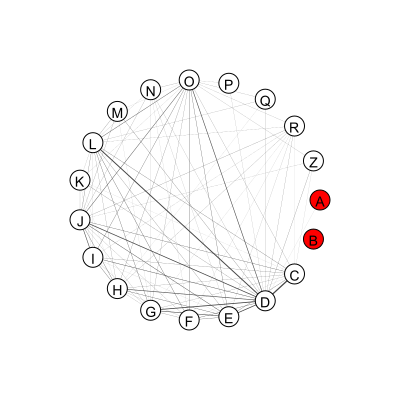

In [14]:
import networkx as nx
from skmultilearn.cluster import IGraphLabelGraphClusterer
import igraph as ig

graph_builder = LabelCooccurrenceGraphBuilder(weighted=True, include_self_edges=False)
edge_map = graph_builder.transform(ytrain_tfidf_ngram)

def to_membership_vector(partition):
    return {
        member :  partition_id
        for partition_id, members in enumerate(partition)
        for member in members
    }


clusterer = IGraphLabelGraphClusterer(graph_builder=graph_builder, method='walktrap')
partition = clusterer.fit_predict(xtrain_tfidf_ngram,ytrain_tfidf_ngram)
membership_vector = to_membership_vector(partition)

colors = ['red', 'white', 'blue']
visual_style = {
    "vertex_size" : 20,
    "vertex_label": multilabel.classes_,
    "edge_width" : [10*x/ytrain_tfidf_ngram.shape[0] for x in clusterer.graph_.es['weight']],
    "vertex_color": [colors[membership_vector[i]] for i in range(ytrain_tfidf_ngram.shape[1])],
    "bbox": (400,400),
    "margin": 80,
    "layout": clusterer.graph_.layout_circle()

}

ig.plot(clusterer.graph_, **visual_style)

In [57]:
from skmultilearn.ensemble import LabelSpacePartitioningClassifier, MajorityVotingClassifier
from skmultilearn.problem_transform import ClassifierChain

params = {'C': 0.5, 'loss': 'hinge', 'multi_class': 'ovr', 'penalty': 'l2', 'class_weight': 'balanced'}
classifier = MajorityVotingClassifier(
    classifier = ClassifierChain(LinearSVC(**params)),
    clusterer = clusterer
)

classifier.fit(xtrain_tfidf_ngram.toarray(), ytrain_tfidf_ngram)


MajorityVotingClassifier(classifier=ClassifierChain(classifier=LinearSVC(C=0.5,
                                                                         class_weight='balanced',
                                                                         loss='hinge'),
                                                    require_dense=[True, True]),
                         clusterer=<skmultilearn.cluster.igraph.IGraphLabelGraphClusterer object at 0x00000260E73FC5E0>,
                         require_dense=[False, False])

In [58]:
prediction = classifier.predict(xtest_tfidf_ngram)
print_ml_score(ytest_tfidf_ngram, prediction.toarray(), classifier)

Classifier:  MajorityVotingClassifier
Accuracy Score: 0.5393731933668036
-----------------------------------
